In [ ]:
# ======================================================
# NOTEBOOK 6 — VGG16 Feature Extraction + Linear SVM
# NO PCA (simple version)
# ======================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))



TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ------------------------------------------------------
# 1) Paths & Config
# ------------------------------------------------------
IMAGE_FOLDER = "/content/drive/MyDrive/HAM10000_images"   # where images live (Notebook1 should have created/cleaned this)
SPLITS_DIR = "/content/drive/MyDrive/splits"              # output from Notebook 1: df_train.csv, df_val.csv, df_test.csv
OUTPUT_DIR = "/content/drive/MyDrive/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32



In [ ]:
# ------------------------------------------------------
# 2) Load CSV splits
# ------------------------------------------------------
df_train = pd.read_csv(f"{SPLITS_DIR}/df_train.csv")
df_val   = pd.read_csv(f"{SPLITS_DIR}/df_val.csv")
df_test  = pd.read_csv(f"{SPLITS_DIR}/df_test.csv")

print(len(df_train), len(df_val), len(df_test))

# Ensure filepath exists
for df in [df_train, df_val, df_test]:
    if 'filepath' not in df.columns:
        df['filename'] = df['image_id'].astype(str) + '.jpg'
        df['filepath'] = df['filename'].apply(lambda x: os.path.join(IMAGE_FOLDER, x))




29491 861 1780


In [ ]:
# ------------------------------------------------------
# 3) Data generators (NO augmentation)
# ------------------------------------------------------
gen = ImageDataGenerator(preprocessing_function=vgg_preprocess)

flow_train = gen.flow_from_dataframe(
    df_train, x_col='filepath', y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

flow_val = gen.flow_from_dataframe(
    df_val, x_col='filepath', y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

flow_test = gen.flow_from_dataframe(
    df_test, x_col='filepath', y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

class_map = flow_train.class_indices
inv_class = {v:k for k,v in class_map.items()}
print("Classes:", inv_class)



Found 29491 validated image filenames belonging to 7 classes.
Found 861 validated image filenames belonging to 7 classes.
Found 1780 validated image filenames belonging to 7 classes.
Classes: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


In [ ]:
# ------------------------------------------------------
# 4) Load VGG16 feature extractor (GAP output = 512 dims)
# ------------------------------------------------------
base = VGG16(weights='imagenet', include_top=False,
             input_shape=(IMG_SIZE, IMG_SIZE, 3))

feat_model = Model(inputs=base.input,
                   outputs=GlobalAveragePooling2D()(base.output))

feat_model.summary()
3



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ------------------------------------------------------
# 5) Feature extraction function
# ------------------------------------------------------
def extract_features(generator, model):
    steps = int(np.ceil(generator.n / generator.batch_size))
    features = model.predict(generator, steps=steps, verbose=1)
    labels = generator.classes
    return features, labels




In [ ]:
# ------------------------------------------------------
# 6) Extract features for train/val/test
# ------------------------------------------------------
X_train, y_train = extract_features(flow_train, feat_model)
X_val, y_val     = extract_features(flow_val, feat_model)
X_test, y_test   = extract_features(flow_test, feat_model)

print("Feature shape:", X_train.shape)   # expected (num_samples, 512)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


922/922 ━━━━━━━━━━━━━━━━━━━━ 355s 368ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 869ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step
Feature shape: (29491, 512)


In [ ]:
# ------------------------------------------------------
# 7) Build Linear SVM (simple, no PCA)
# ------------------------------------------------------
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=1, max_iter=5000))
])

svm_model.fit(X_train, y_train)


svm_model.fit(X_train, y_train)



/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', LinearSVC(C=1, max_iter=5000))])

In [ ]:
# ------------------------------------------------------
# 8) Validation Accuracy
# ------------------------------------------------------
y_val_pred = svm_model.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {acc_val*100:.2f}%")




Validation Accuracy: 66.67%



Test Accuracy: 61.69%

Classification Report:
              precision    recall  f1-score   support

       akiec       0.18      0.37      0.25        54
         bcc       0.27      0.33      0.30        89
         bkl       0.37      0.45      0.41       205
          df       0.16      0.29      0.20        21
         mel       0.32      0.45      0.37       220
          nv       0.90      0.72      0.80      1171
        vasc       0.50      0.55      0.52        20

    accuracy                           0.62      1780
   macro avg       0.39      0.45      0.41      1780
weighted avg       0.70      0.62      0.65      1780



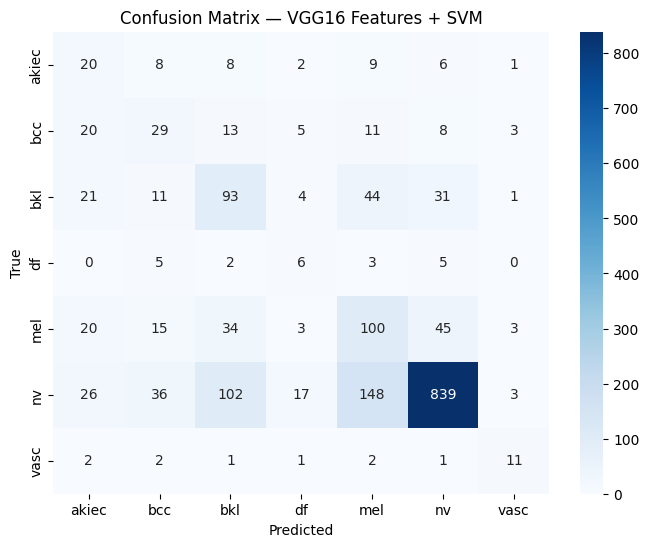

In [ ]:
# ------------------------------------------------------
# 9) Test Accuracy + Report
# ------------------------------------------------------
y_test_pred = svm_model.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {acc_test*100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=list(inv_class.values())))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=inv_class.values(),
            yticklabels=inv_class.values(),
            cmap="Blues")
plt.title("Confusion Matrix — VGG16 Features + SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [ ]:
# ------------------------------------------------------
# 10) Save SVM model
# ------------------------------------------------------
import joblib
joblib.dump(svm_model, f"{OUTPUT_DIR}/svm_vgg_features.joblib")

print("\nSaved model to:", f"{OUTPUT_DIR}/svm_vgg_features.joblib")



In [ ]:
# ------------------------------------------------------
# 11) Predict on uploaded image
# ------------------------------------------------------
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(img_path):
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = vgg_preprocess(arr)

    feat = feat_model.predict(arr)
    pred = svm_model.predict(feat)[0]
    label = inv_class[pred]
    return label

print("Upload an image:")
uploaded = files.upload()

for fn in uploaded.keys():
    p = predict_image(fn)
    print(f"{fn} ➜ Predicted class: {p}")
